In [30]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabel
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [32]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabel.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabel.from_abbreviation, data_test))

In [33]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [34]:
y_pred = model.predict(X_test)

In [35]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.7224891793048757

In [36]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] != CrfLabel.NG:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = edit_dist(y_pred[i], y_test[i]) / len(y_test[i])
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

0.400 wa N cha N su -> wa N
1.000 ko N mi Q sho N -> ko N
0.286 ko N kyu u ba i N -> ko N
0.000 mi ni su ka a to -> mi ni
0.000 ta a fu ko o su -> ta a fu
0.000 de ri ka te Q se N -> de ri ka
0.000 pu ro se N to -> pu ro
1.000 ji su te N pa a -> ji su
0.000 mo N ki i su pa na -> mo N ki i
0.000 kya bu re ta a -> kya bu
0.143 ko ra bo re e sho N -> ko ra bo re
0.000 sha a pu pe N shi ru -> sha a pu
0.000 ju ra ru mi N -> ju ra
0.000 fu ro N to o fi su -> fu ro N to
0.000 e pu ro N su te e ji -> e pu ro N
0.500 ra i thi N gu ta bu re Q to -> ra i ta bu
0.571 re mo N su ka Q shu -> re mo N
0.625 se Q ku su fu re N do -> se Q ku su
0.000 pu ro pa ga N da -> pu ro
0.000 ri ha bi ri te e sho N -> ri ha bi ri
1.000 tsu i N be Q do -> be Q do
0.091 to ra N ji su ta a me ga ho N -> to ra N me ga
0.125 mi ku ro su ko pi Q ku -> mi ku
1.000 o o de ko ro N -> o o de
1.000 ra ji o te su ta a -> ra ji o
0.375 me ri i ku ri su ma su -> me ri i
0.286 mi su ko N te su to -> mi su
0.000 fu ri i ra N su 

In [37]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.47244094488188976


(array([123.,  14.,  24.,  12.,  15.,  21.,   9.,  10.,   5.,  21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

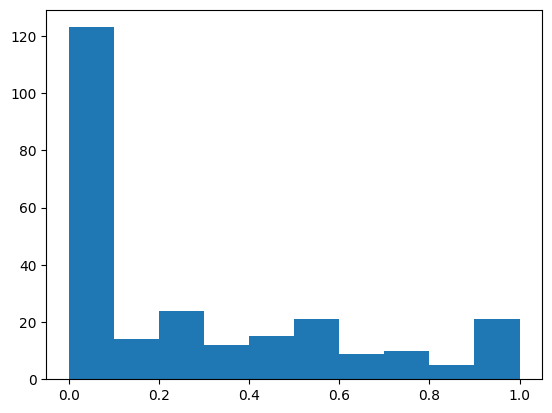

In [38]:
plt.hist(score_list, bins=10)